# Salary Predictions Based on Job Descriptions



# DEFINE

### ---- 1 Define the problem ----

Description:
In this project we are trying to **Predict Salaries** for different job types.
Some of the features that we will be looking are as follows:
* Job Type: Designation of the Job.
* Degree: What degree does the person have.
* Major: Type of Major.
* Industry: Type of Industry
* YearsExperience: Years of Experience working
* Miles From Metropolis: How far is the job from City

There are different features we will look into and try to extract the important features which directly are responsible to predict the salary for the user.

In [1]:
#import your libraries
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn import preprocessing
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate,KFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
import pickle

#Author Info
__author__ = "Raj Shah"
__email__ = "rajpareshshah14@gmail.com"

# DISCOVER

### ---- 2 Load the data ----
Loading the data from the csv files provided.
Includes 3 files:
* train_features.csv
* test_features.csv
* train_salaries.csv

In [46]:
#load the data into a Pandas dataframe
def load_data():
    train_features = pd.read_csv('../data/train_features.csv',encoding="utf8")
    test_features = pd.read_csv('../data/test_features.csv', encoding="utf8")
    train_target = pd.read_csv('../data/train_salaries.csv',encoding="utf8")
    return train_features,test_features,train_target

train_df,test_df,train_target = load_data()
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


### ---- 3 Clean the data ----

Here we check for Duplicates, Null values, outliers and clean the data.
This preprocessing steps is important which can help later in modeling

In [160]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
train_df.jobId.duplicated().sum()

0

Here we see all the **JOB ID** are unique and there is no duplicate value.

In [4]:
train_df.describe()

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


We observe the mean years of experience is **12 years** and max years of experience is **24 years**.

The mean distance from the nearest metropolis is **49 miles**.

In [5]:
# Checking for Null values
train_df.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

The data is pretty clean and we don't observe any null values in the data.

In [6]:
#Separating the different features into categorical and Numerical features
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


We see there are two numerical Variables and six categorical variables

In [7]:
categorical = ['jobId','companyId','jobType','degree','major','industry']
numerical = ['yearsExperience','milesFromMetropolis']


In [48]:
# Merging the train and target dataFrame
train_data = pd.merge(train_df,train_target)
train_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [49]:
# Checking if there are any anamolies in the target Variable.
zeroSalary = train_data[train_data['salary'] <= 0]
train_data = train_data.drop(zeroSalary.index,axis=0)

We observe that **Some of the Job Type** has 0 salary, which is not possible given the yearsExperience and Degree.
Since there are only 5 values we can remove this entries from the data set.

In [50]:
# Resetting the Index for the Data Frame
train_data = train_data.reset_index(drop=True)
train_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [12]:
train_data.tail()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
999990,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999991,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999992,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999993,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149
999994,JOB1362685407686,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,88


### ---- 4 Explore the data (EDA) ----

In [51]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

def plot_box(col):
    '''
    Plots the box plot for individual Column and Target Variable salary
    params: 
    input: Column Name
    output: Plot
    '''
    plt.figure(figsize=(14,6))
    sns.boxplot(x=col,y='salary',data=train_data)
    if col == 'companyId':
        plt.xticks(rotation=90)

def get_description(col):
    '''
    Gives the description for the column Type with respect to Salary
    input: Column Name
    '''
    return train_data.groupby(col)['salary'].describe()
    
def get_unique_val(col):
    '''
    Gives Unique Names for a particular Categorical Column.
    '''
    return train_data[col].unique()
    

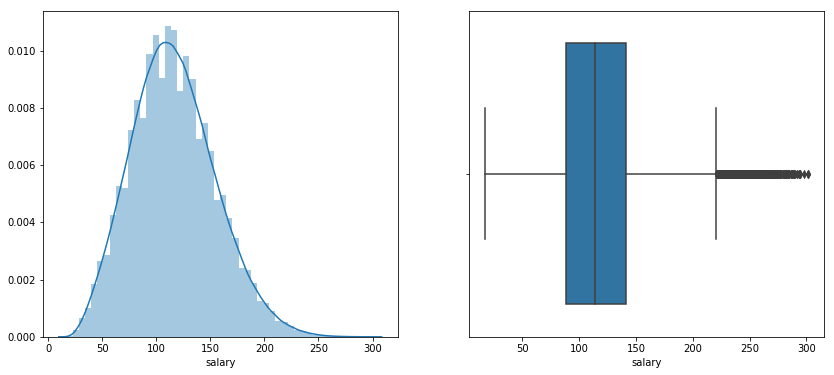

In [52]:
# Observing our target variable
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.distplot(train_data['salary'])
plt.subplot(1,2,2)
sns.boxplot(train_data['salary'])

In [13]:
#Getting the Skewness of our data
skew(train_data['salary'])

0.3465267592829531

* We can observe here that our salary is **right skewed**. We can verify this by calculating the skew. The value for **Skew** is **0.3465**. As the value is positive, it indicated the data is right skewed.
* From the boxplot we can observe there are some outliers towards the rigth side of the data and it would be good the check the tail for some outliers and remove them

In [14]:
salary_stat = train_data['salary'].describe()
IQR = salary_stat['75%'] - salary_stat['25%']
lowb = salary_stat['25%'] - 1.5*IQR
uppb = salary_stat['75%'] + 1.5*IQR
train_data[train_data['salary'] > uppb].head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
266,JOB1362684407953,COMP30,CEO,MASTERS,BIOLOGY,OIL,23,60,223
362,JOB1362684408049,COMP38,CTO,MASTERS,NONE,HEALTH,24,3,223
560,JOB1362684408247,COMP53,CEO,MASTERS,BIOLOGY,WEB,22,7,248
670,JOB1362684408357,COMP26,CEO,MASTERS,MATH,AUTO,23,9,240
719,JOB1362684408406,COMP54,VICE_PRESIDENT,DOCTORAL,BIOLOGY,OIL,21,14,225


In [99]:
# Observing the Unique Job Type
get_unique_val('jobType')

array(['CFO', 'CEO', 'VICE_PRESIDENT', 'MANAGER', 'JUNIOR', 'JANITOR',
       'CTO', 'SENIOR'], dtype=object)

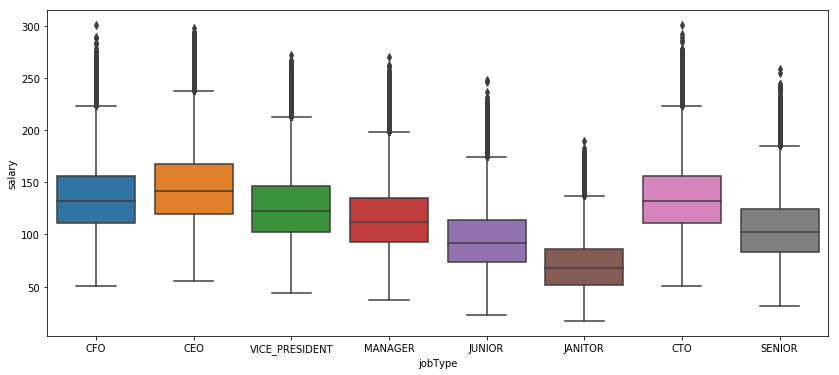

In [84]:
plot_box('jobType')

* We can observe here the **Janitor, Junior** positions have a lower starting salary.
* Higher positions like **CFO CEO CTO** have amongst the highest salary as can be seen from the plot.
* Mid Level positions like **Manager Senior Vice President** have a similar salary range.

This gives an intuition to break the jobtype into different buckets that can help in feature Engineering

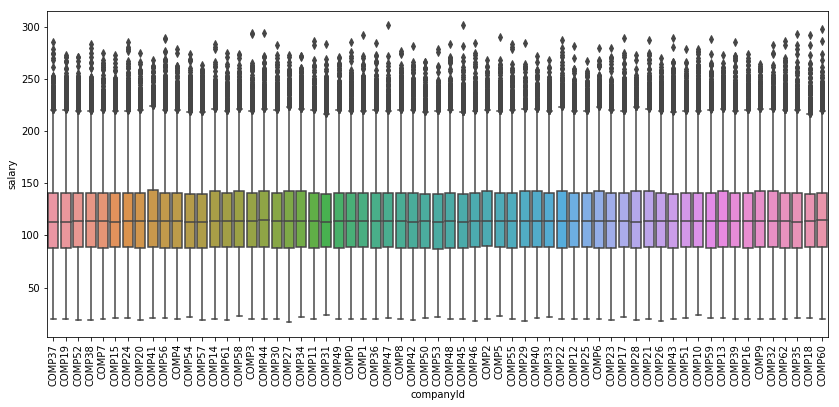

In [89]:
# Distribution of salaries across different companies
plot_box('companyId')

We can see that distribution of Salaries across different Companies is almost the same.
This wouldn't be a good predictor to predict the out put salary.

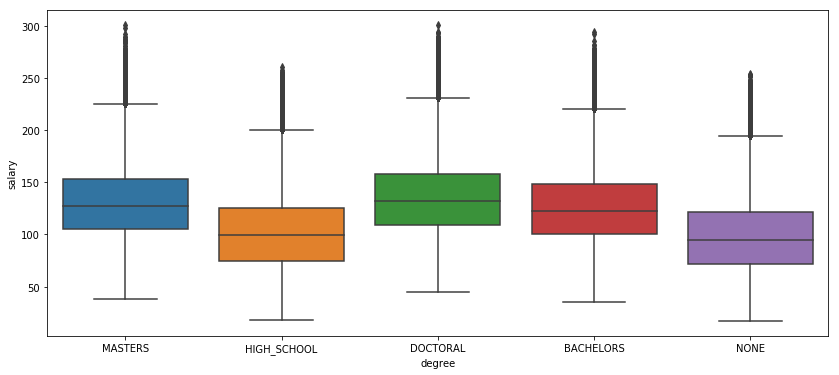

In [92]:
plot_box('degree')

Here we can observe the plot with respect to degree and Salary.
A person who **doesn't have a degree** or just the **High School** degree have low Salary as compared to a person with **Bachelors** , **Masters** or **Doctoral** degrees.

This can also give us an intuition to be used as a feature to predict the salary.

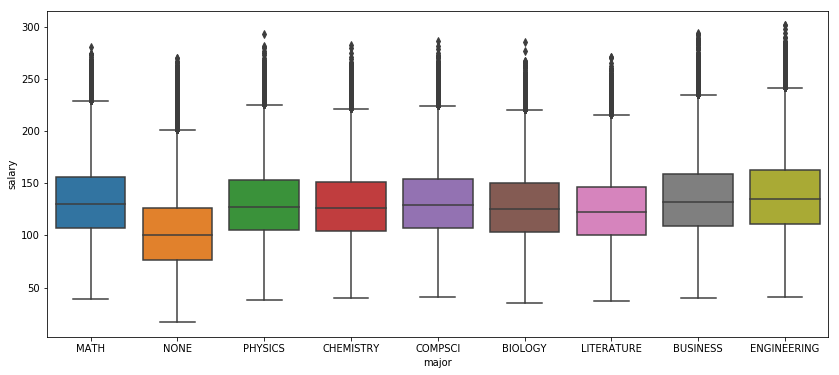

In [113]:
plot_box('major')

I observe here that someone who has some kind of major has a higher salary compared to someone with a major None.
I would like to explore more to see if major is responsible for a higher Salary.

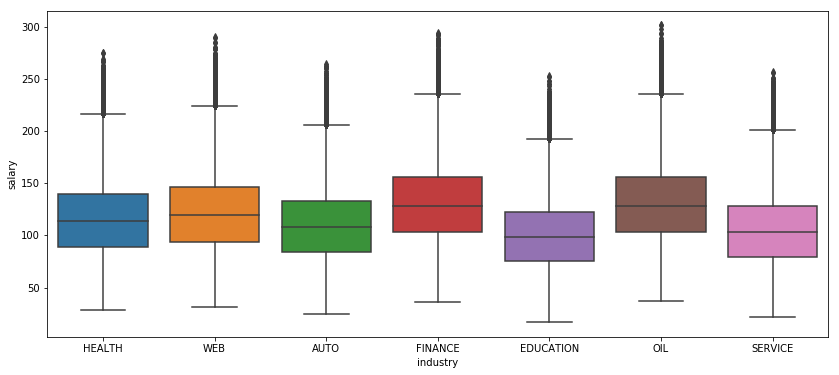

In [122]:
plot_box('industry')

In [123]:
get_description('industry')

,count,mean,std,min,25%,50%,75%,max
industry,,,,,,,,
AUTO,142941.0,109.435222,36.091590,25.0,84.0,108.0,133.0,264.0
EDUCATION,142819.0,99.448386,35.110257,17.0,75.0,98.0,122.0,253.0
FINANCE,142866.0,130.747659,38.319820,36.0,103.0,128.0,156.0,294.0
HEALTH,142755.0,115.735540,36.865179,28.0,89.0,114.0,140.0,275.0
OIL,142770.0,130.953863,38.528558,37.0,103.0,128.0,156.0,301.0
SERVICE,142639.0,104.446820,35.577606,22.0,79.0,103.0,128.0,256.0
WEB,143205.0,121.645362,38.165659,31.0,94.0,119.0,146.0,290.0


We can observe the highest mean salary for **OIL** and **FINANCE** industries.
Industry can be a good feature in order to predict the salary.

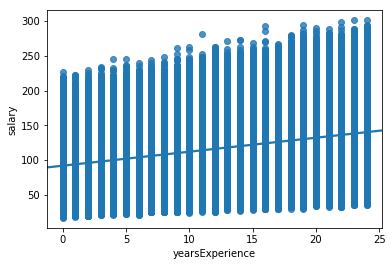

In [124]:
sns.regplot(x=train_data['yearsExperience'],y=train_data['salary'])

As **Years of Experience** increases your **Salary** increases as well. This can be a good feature because of the linear relationship

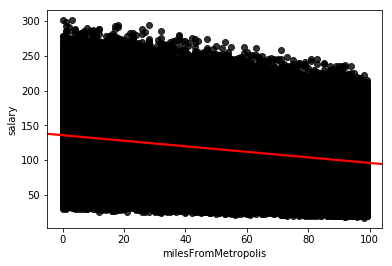

In [128]:
sns.regplot(x=train_data['milesFromMetropolis'],y=train_data['salary'],scatter_kws={"color": "black"}, line_kws={"color": "red"})

In [53]:
# Converting features into Categorical and Numerical
train_data['jobType'] = train_data['jobType'].astype('category')
train_data['degree'] = train_data['degree'].astype('category')
train_data['major'] = train_data['major'].astype('category')
train_data['industry'] = train_data['industry'].astype('category')


In [54]:
# Dropping the Job ID and Company ID which are useful for predicting the Salary 
train_data = train_data.drop(['jobId','companyId'],axis=1)


In [18]:
def encode_label(col):
    '''
    Encoded the labels for categorical variables
    params: inp: Name of the categorical column
    '''
    le = preprocessing.LabelEncoder()
    encoded_data[col] = le.fit_transform(encoded_data[col])
    
encoded_data = train_data[:]
encode_label('major')
encode_label('degree')
encode_label('industry')
encode_label('jobType')
encoded_data.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,1,3,6,3,10,83,130
1,0,2,7,6,3,73,101
2,7,1,8,3,10,38,137
3,5,1,2,0,8,17,142
4,7,0,8,2,8,16,163


In [166]:
def encode_onehot(df):
    '''
    Encodes the categorical variables to into one hot feature vectors
    params: inp: Training DataFrame
    '''
    df = pd.get_dummies(df)
    return df
    
train_data = encode_onehot(train_data)
train_data.head()

,yearsExperience,milesFromMetropolis,salary,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,10,83,130,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,3,73,101,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,10,38,137,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,8,17,142,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,8,16,163,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


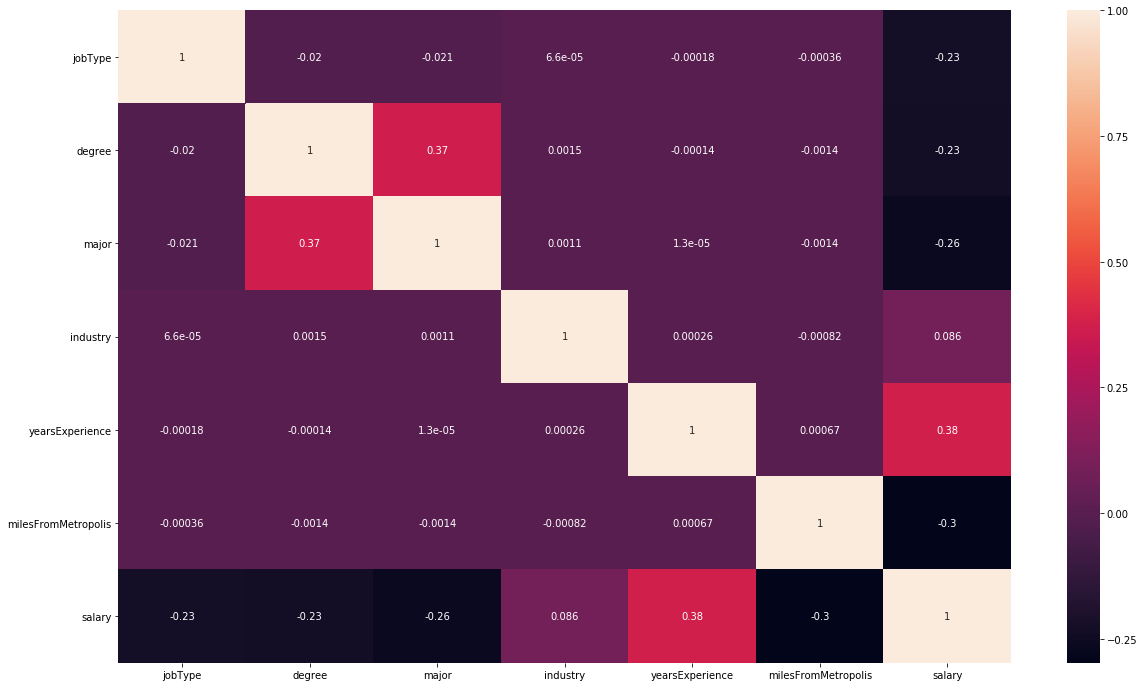

In [20]:
#Creating a correlation matrix to observe which features are important
plt.figure(figsize=(20,12))
corr_mat = encoded_data.corr()
sns.heatmap(corr_mat,annot=True)

From the heatmap, we can observe positive correlation between **yearsofExperience** and **Salary**
We can also observe a negative correlation between **milesFromMetropolis** and **Salary**

In [55]:
maxSalary = pd.DataFrame({'maxSalary':train_data.groupby('industry')['salary'].max(),'avgSalary':train_data.groupby('industry')['salary'].mean()})
maxSalary = maxSalary.sort_values(by=['maxSalary'])
maxSalary.reset_index(inplace=True)

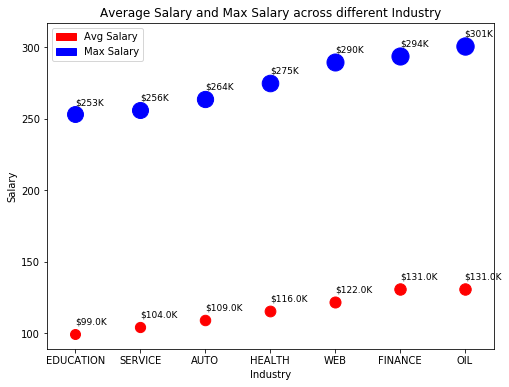

In [56]:
plt.figure(figsize=(8,6))
# plt.scatter(maxSalary['industry'], maxSalary['avgSalary'],s= maxSalary['avgSalary'], color='b')
for i in range(len(maxSalary)):
    x = maxSalary['industry'][i]
    y = maxSalary['avgSalary'][i]
    plt.scatter(x, y, s = y, color='red')
    plt.text(x,y+7, s = '$'+str(round(maxSalary['avgSalary'][i]))+'K', fontsize=9)

for i in range(len(maxSalary)):
    x = maxSalary['industry'][i]
    y = maxSalary['maxSalary'][i]
    plt.scatter(x, y, s = y ,color='blue')
    plt.text(x,y+7, s = '$'+str(round(maxSalary['maxSalary'][i]))+'K', fontsize=9)
plt.xlabel('Industry')
plt.ylabel('Salary')
red_patch = mpatches.Patch(color='red', label='Avg Salary')
blue_patch = mpatches.Patch(color='blue', label='Max Salary')
plt.legend(handles=[red_patch,blue_patch])
plt.title("Average Salary and Max Salary across different Industry")

plt.show()


From the above chart we can see that the maximum Salary is offered in **OIL and GAS** industry,followed by **Finance** and **Web**

Average Salary is also highest in **OIL and GAS** domain. 

### ---- 5 Establish a baseline ----

For my baseline Model, I will use Linear Regression model with cross Validation and calculate the MSE

In [167]:
target = train_data['salary']
train_data = train_data.drop(['salary'],axis=1)

In [106]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(train_data)
scaled_df.shape

(999995, 31)

In [114]:
#Splitting the data into Train and Test
X_train,X_test,y_train,y_test = train_test_split(scaled_df,np.array(target),random_state = 42, test_size=0.2)

In [115]:
lm = LinearRegression()
model = lm.fit(X_train,y_train)

In [122]:
preds = model.predict(X_test)
print("Linear Model, R2 Score: {}".format(str(r2_score(preds,y_test))))
print("Linear Model, MSE: {}".format(str(mean_squared_error(preds,y_test))))

Linear Model, R2 Score: 0.6545906611351511
Linear Model, MSE: 383.2825344315664


Can we improve the baseline by doing Cross Validation?

In [137]:
# Performing cross validation for our Baseline Model using 5 cross Validations
r2_score_cv = cross_val_score(model, X_train, y_train, cv=5,scoring = 'neg_mean_squared_error')
print("Linear Model, Train MSE: {}".format(abs(np.mean(r2_score_cv))))

Linear Model, Train MSE: 384.68522549728476


In [136]:
preds = cross_val_predict(model,X_test,y_test,cv=5)
print("Linear Model, Prediction MSE: {}".format(str(mean_squared_error(preds,y_test))))

Linear Model, Prediction MSE: 383.3483770978489


The **MSE** error for BaseLine Model on prediction set is **~384**.


### ---- 6 Hypothesize solution ----

To improve my Baseline MSE, possibly using of a deeper models such as Decision Tree or Gradient Boosting may help improve and get an efficient model.
* Lasso or Ridge Regression
* Random Forest Regressor
* XGBoost

## Part 3 - DEVELOP

### ---- 7 Engineer features  ----

In [150]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

def yearsExperiencebucket(x):
    if 0 < x < 6:
        return "Entry Level"
    elif 6 <= x < 11:
        return "Mid Senior Level"
    elif 11 <= x < 17:
        return "Senior Level"
    elif x >= 17:
        return "Executives"

    
train_data['yearsbucket'] = train_data['yearsExperience'].apply(yearsExperiencebucket)
train_data = train_data.drop(['yearsExperience'],axis=1)


KeyError: 'yearsExperience'

### ---- 8 Create models ----

In [168]:
train_data = encode_onehot(train_data)
train_data.head()

,yearsExperience,milesFromMetropolis,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,10,83,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,3,73,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,10,38,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
3,8,17,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,8,16,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0


In [169]:
X_train,X_test,y_train,y_test = train_test_split(train_data,np.array(target),random_state = 42, test_size=0.2)

In [191]:
def cross_validate(model, df, target_df, num_procs=2):
    kfolds = KFold(n_splits=5, shuffle=True)
    mean_mse = -1.0 * np.mean(cross_val_score(model, df, target_df, cv=kfolds, n_jobs=num_procs,
                                             scoring='neg_mean_squared_error'))
    return mean_mse

In [192]:
# Ridge Rregression
lmRidge = Ridge(alpha=1.0)
mse_lm = cross_validate(lmRidge,X_train,y_train)
print("Linear Model --> Ridge Regressor , MSE Score: {}".format(str(mse_lm)))

Linear Model --> Ridge Regressor , MSE Score: 384.6919755177337


In [171]:
preds = lmRidge.predict(X_test)
print("Linear Model --> Ridge Regressor , R2 Score: {}".format(str(r2_score(preds,y_test))))
print("Linear Model --> Ridge Regressor, MSE: {}".format(str(mean_squared_error(preds,y_test))))

Linear Model --> Ridge Regressor , R2 Score: 0.6545865507747837
Linear Model --> Ridge Regressor, MSE: 383.28261933158063


In [178]:
rf = RandomForestRegressor(n_estimators=60, n_jobs=2, max_depth=25, min_samples_split=60, \
                               max_features=30)
preds = rf.predict(X_test)
print("Random Forest Regressor , R2 Score: {}".format(str(r2_score(preds,y_test))))
print("Random Forest Regressor, MSE: {}".format(str(mean_squared_error(preds,y_test))))

Random Forest Regressor , R2 Score: 0.6770311631542445
Random Forest Regressor, MSE: 365.12018386767653


In [193]:
mse_rf = cross_validate(rf,X_train,y_train)
print("Random Forest Model, Train MSE: {}".format(str(mse_rf)))

Random Forest Model, Train MSE: 367.276576350211


In [194]:
xgb = XGBRegressor(learning_rate=0.5,n_estimators=460,
                                     max_depth=3,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror')

mse_xgb = cross_validate(xgb,X_train,y_train)
print("XGBoost Model, Train MSE: {}".format(str(mse_xgb)))

XGBoost Model, Train MSE: 356.48308889224785


In [198]:
xgb_m = xgb.fit(X_train,y_train)
preds = xgb_m.predict(X_test)
print("XGBoost Regressor, MSE: {}".format(str(mean_squared_error(preds,y_test))))

XGBoost Regressor, MSE: 355.1321056543311


| Models                | MSE         |
| ----------------------| ----------- |
| Linear Model(Baseline)| 383.3       |
| Ridge Regression      | 383.2       |
| Random Forest         | 365.1       |
| XGBoost Regressor     | 356.4       |

As we can see from the above table **XGBoost** model is the best model with **MSE** of **356.4**
We can use this model and further fine tune by optimizing the hyperparameters.

### ---- 9  Best model  ----
XGBoost Model performs the best with lowest MSE 
#### Hyperparameter Tuning using RandomSearch

In [199]:
# Lets check all the hyperparameters of XGB model
xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=460,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.7, verbosity=1)

In [208]:
params = {
    'learning_rate':[0.01,0.1,0.5],
    'n_estimators':[300,400,500],
    'min_child_weight': [1, 5, 10],
    'max_depth':[3,4,5],
    'subsample':[0.6,0.7],
    'colsample_bytree': [0.6,0.7,0.8]
}

In [209]:
folds = 5
param_comb = 5
kf = KFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='neg_mean_squared_error', n_jobs=4, cv=kf.split(X_train,y_train), verbose=3, random_state=1001 )
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 85.1min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x1c4968f48>,
                   error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=0.7, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.5, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=460,
                                          n_jobs=...
                                          seed=None, silent=None, subsample=0.7,
                                          verbosity=1),
                   iid='warn', n_iter=5, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6,

In [210]:
preds = random_search.predict(X_test)
print("XGBoost Regressor, MSE: {}".format(str(mean_squared_error(preds,y_test))))

XGBoost Regressor, MSE: 354.5609977138933


## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [2]:
#Pipeline: LoadData --> PreProcess and Clean --> Fit --> Predict 
def load_data():
    '''
    Loads the Train and test data from the csv File
    Return:
    train and test Data
    '''
    train_features = pd.read_csv('../data/train_features.csv',encoding="utf8")
    test_features = pd.read_csv('../data/test_features.csv', encoding="utf8")
    train_target = pd.read_csv('../data/train_salaries.csv',encoding="utf8")
    return train_features,test_features,train_target

def concat_data(df1,df2):
    '''Concatenates two data frames'''
    return pd.concat([df1,df2],ignore_index=False)

def merge_data(df1,df2):
    '''Merges two Data Frames'''
    return pd.merge(df1,df2)

def clean_data():
    '''
    Cleaning the data, removing null values
    '''
    train_data, test_data, target = load_data()
    train_target = merge_data(train_data,target)
    train_target = train_target.drop(train_target[train_target['salary'] <= 0].index,axis = 0)
    train_data = train_target.drop(['salary'],axis = 1)
    train_data = train_data.drop(['jobId','companyId'],axis=1)
    test_data = test_data.drop(['jobId','companyId'],axis=1)
    train_data = train_data.reset_index(drop=True)
    target = train_target['salary']
    return train_data,test_data,target

def describe_data(df):
    print("Data has following columns:")
    print(df.columns)
    print()
    print("Data has following numerical Features")
    print(df.describe(include=[np.number]))
    print()
    print("Data has following Categorical Columns")
    print(df.describe(include=['O']))
    
def encode_onehot(df):
    '''
    Encodes the categorical variables to into one hot feature vectors
    params: inp: Training DataFrame
    '''
    df = pd.get_dummies(df)
    return df

def train_test(df,target):
    '''
    Splitting the data for Train and Testing
    '''
    X_train,X_test,y_train,y_test = train_test_split(df,np.array(target),random_state = 42, test_size=0.2)
    return X_train,X_test,y_train,y_test

def model_fn(df,tar,test_df,test_l):
    '''
    Define Model,fit the data and get mean squared error.
    '''
    model = XGBRegressor(learning_rate=0.5,n_estimators=460,
                        max_depth=3,gamma=0, subsample=0.7,
                        colsample_bytree=0.7,objective='reg:squarederror')
    model.fit(df,tar)
    preds = model.predict(test_df)
    mse = mean_squared_error(preds,test_l)
    print("XGBoost Regressor, MSE: {}".format(str(mse)))
    return model,mse
    
def model_predict(model,df):
    '''
    Returns the prediction for the test set
    '''
    preds = model.predict(df)
    return preds

def save_preds(preds):
    '''
    Saving the Predictions to csv file
    '''
    np.savetxt('prediction.csv',preds,delimiter=',')
    print("Predictions saved to the disk")
    
def Pipeline():
    '''
    Complete Training pipeline, gets the data, preprocess it, fits a model and saves the output in csv file
    '''
    train_data,test_data,target = clean_data()
    describe_data(train_data)
    train_data = encode_onehot(train_data)
    test_data = encode_onehot(test_data)
    train_feat , test_feat, train_label,test_label = train_test(train_data,target)
    model,mse = model_fn(train_feat,train_label,test_feat,test_label)
    preds = model_predict(model,test_data)
    save_preds(preds)
    pickle.dump(model, open("salarymodel.pkl", 'wb'))
    print("Saved the model to Disk")
    print("Completed the Pipeline!!")
    

In [3]:
Pipeline()            

Data has following columns:
Index(['jobType', 'degree', 'major', 'industry', 'yearsExperience',
       'milesFromMetropolis'],
      dtype='object')

Data has following numerical Features
       yearsExperience  milesFromMetropolis
count    999995.000000        999995.000000
mean         11.992407            49.529381
std           7.212390            28.877721
min           0.000000             0.000000
25%           6.000000            25.000000
50%          12.000000            50.000000
75%          18.000000            75.000000
max          24.000000            99.000000

Data has following Categorical Columns
       jobType       degree   major industry
count   999995       999995  999995   999995
unique       8            5       9        7
top     SENIOR  HIGH_SCHOOL    NONE      WEB
freq    125886       236975  532353   143205
XGBoost Regressor, MSE: 355.1321056543311
Predictions saved to the disk
Saved the model to Disk
Completed the Pipeline!!


## Summary

Successfully completed the analysis and training for Salary Prediction problem for different job type. Performed **Exploratory Data Analysis** to get insights from the data and then preprocessed the data accordingly inorder to fit a model.
Established a Baseline Linear regression model and observed MSE of **383**.
Improved the Baseline score by chossing different models and doing cross Validation and achieved the Final MSE of **355** using **XGBoost Model**
Automated the complete pipeline and saved the predictions onto the disk.